# Contour: More Functions

[06:53:32] INFO - Showing image ... (12.35 x 8.2)
[06:53:32] INFO - Showing image ... (12.35 x 8.2)


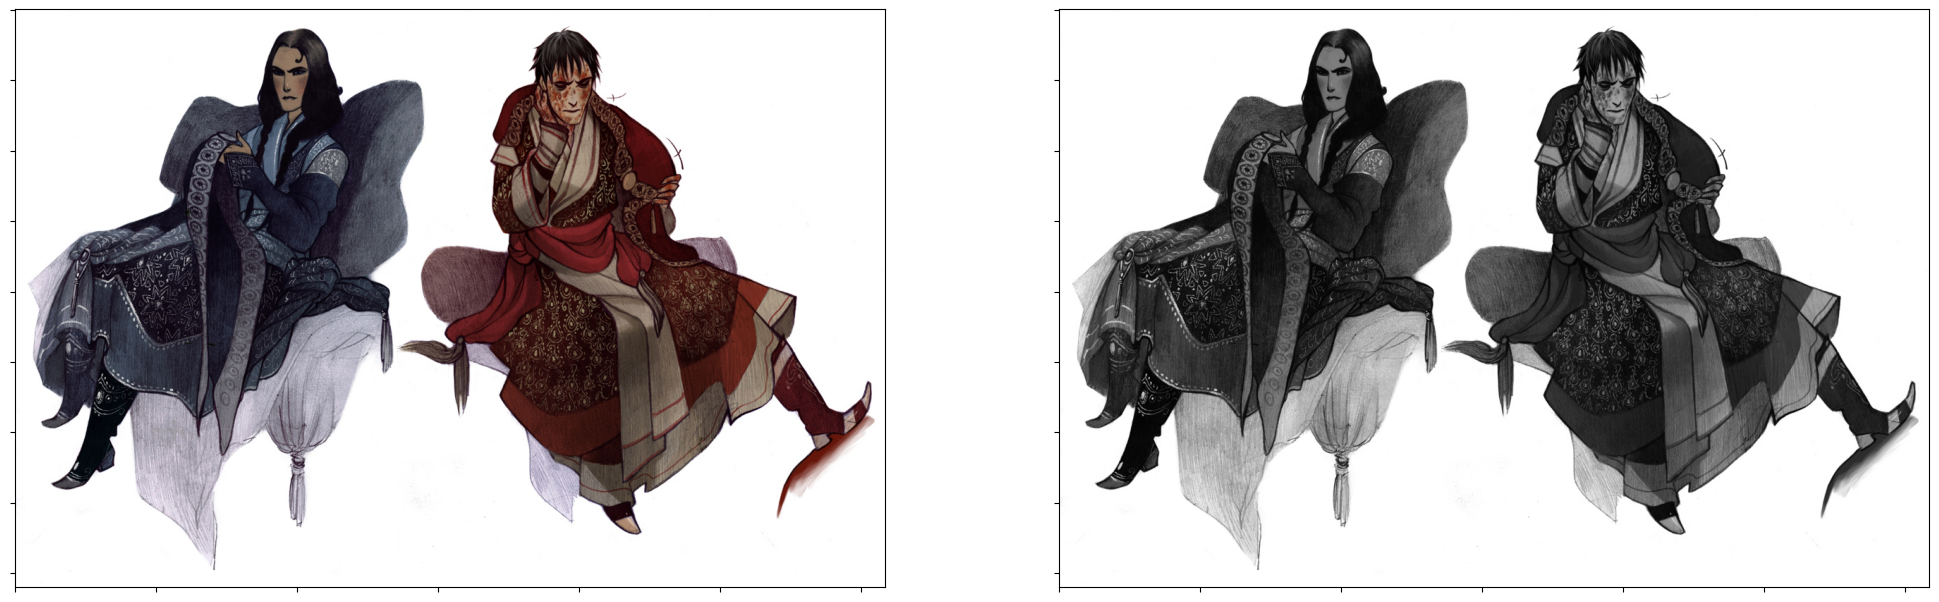

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from custom_utils import *

import logging
logging.basicConfig(
    #  filename='log_file_name.log',
     level=logging.INFO, 
     format= '[%(asctime)s] %(levelname)s - %(message)s',
     datefmt='%H:%M:%S'
)

height, width, img, img_rgb, img_gray = load_image_and_show('../data/phobs1.jpeg')

[06:53:33] INFO - Showing image ... (12.35 x 8.2)


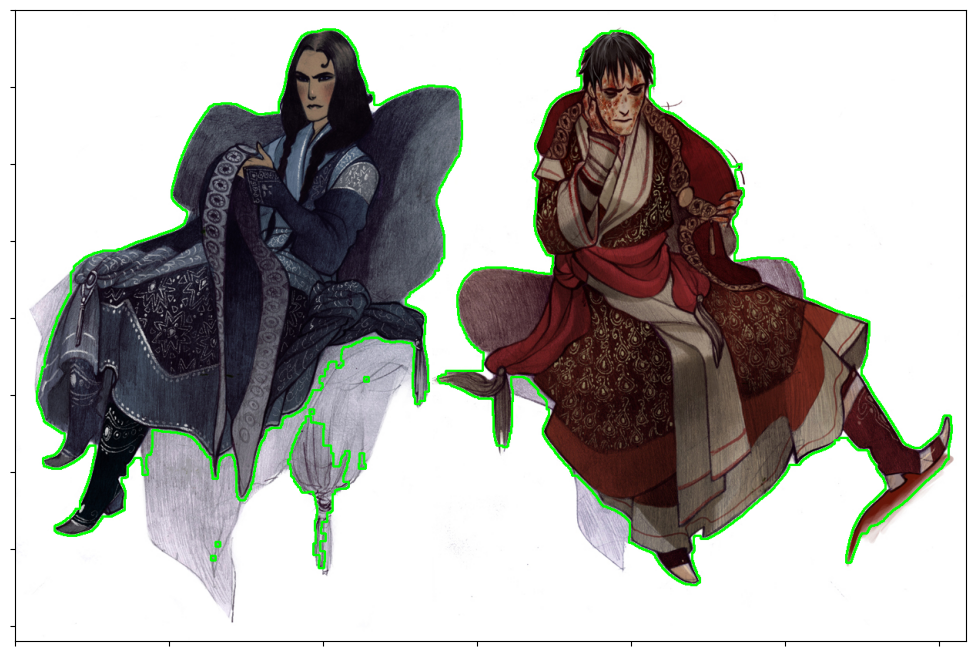

In [3]:
kernel = np.ones((5, 5), np.float32) / 25

_, img_binary = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
img_processed = cv.morphologyEx(img_binary, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
img_processed = cv.morphologyEx(img_processed, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=5)
img_processed = cv.filter2D(img_processed, -1, kernel)

contours, _ = cv.findContours(img_processed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_contoured = cv.drawContours(img_rgb.copy(), contours, -1, (0, 255, 0), 2)

show_image(img_contoured)

[06:53:34] INFO - Showing image ... (12.35 x 8.2)


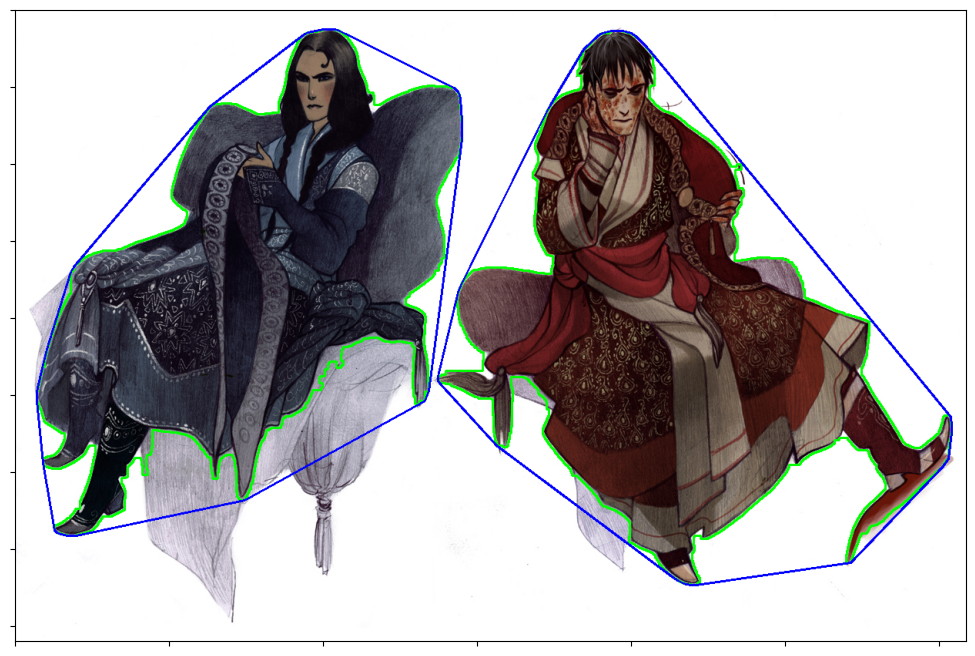

In [4]:
# check the area of each countour, and extract the two biggest ones
areas = np.array([cv.contourArea(c) for c in contours])
selected_idx = areas.argsort()[-2:]

# collect the hulls of the two biggest contours
hulls = [cv.convexHull(contours[idx]) for idx in selected_idx]

img_ = img_rgb.copy()
_, ax = plt.subplots(1, 1, figsize=(width/100, height/100))
for i, idx in enumerate(selected_idx):
    cv.drawContours(
        img_, [contours[idx]], 0, (0, 255, 0), 2
    )

    cv.drawContours(
        img_, [hulls[i]], 0, (0, 0, 255), 2
    )
show_image( img_, ax = ax )
plt.show()


## Convexity Defects

In [5]:
# Since we are getting the convexity defects, we set returnPoints = False
hulls_ = [cv.convexHull(contours[idx], returnPoints=False) for idx in selected_idx]
defects = [cv.convexityDefects(contours[idx], hull) for idx, hull in zip(selected_idx, hulls_)]
solidities = [
    cv.contourArea(contours[idx]) / cv.contourArea(hulls[i]) for i, idx in enumerate(selected_idx)
]

for idx, solidity in zip(selected_idx, solidities):
    print(f"Contour {idx:2d}  Solidity: {solidity}")

Contour  7  Solidity: 0.7638922438904575
Contour  6  Solidity: 0.743149009486805


defects has the following structure: 

```
[ start_index, end_index, farthest_pt_index, fixpt_depth ]
```

- `start_index` , `end_index` , and `farthest_pt_index` are indices of the contour points (not the hull indices)
- `fixpt_depth` is the distance between the farthest contour point and the hull.

[07:05:47] INFO - Showing image ... (12.35 x 8.2)
[07:05:47] INFO - Showing image ... (12.35 x 8.2)


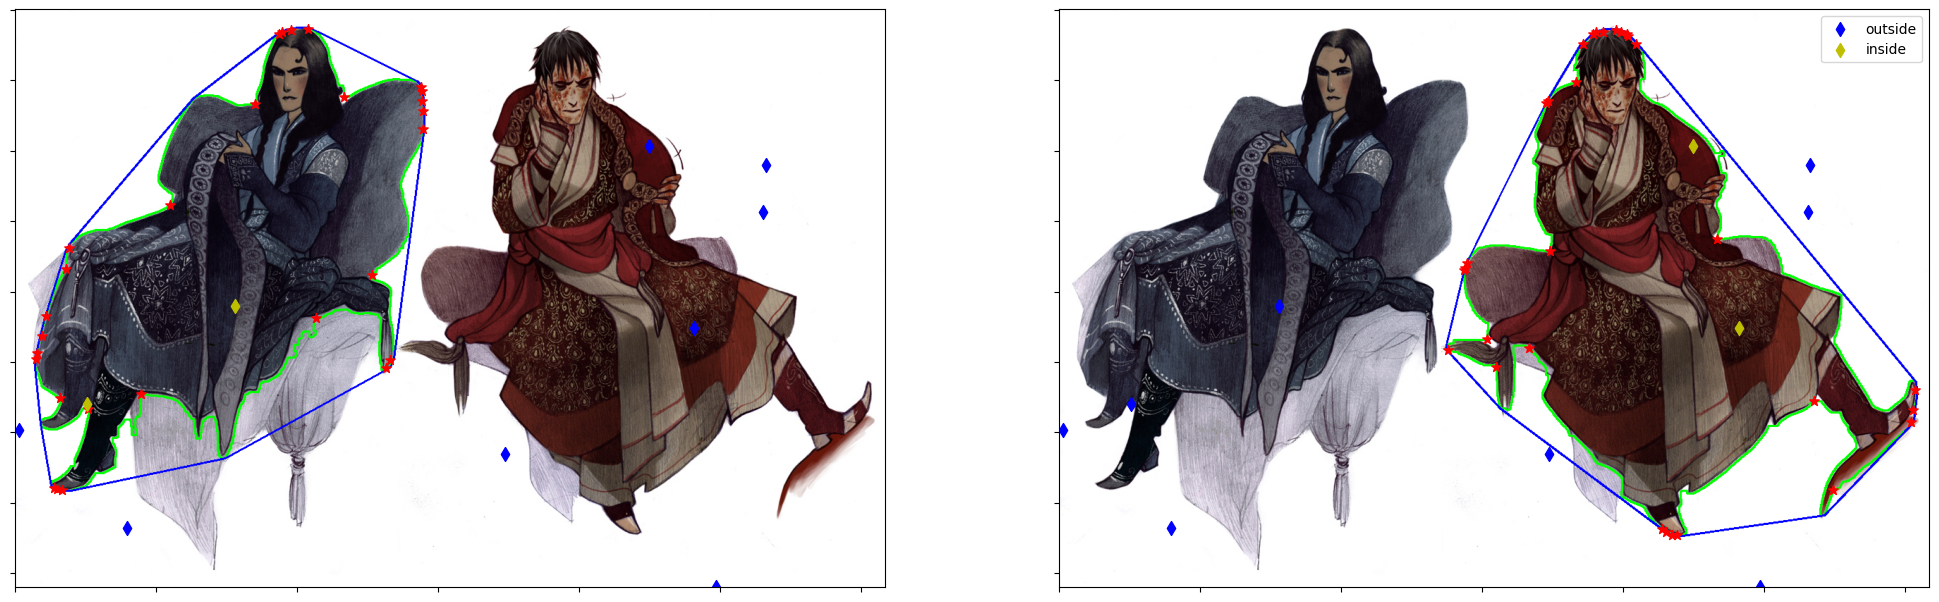

In [37]:
_, ax = plt.subplots(1, len(selected_idx), figsize=(width*len(selected_idx)/100, height/100))
random_pts = np.c_[
    np.random.randint(0, width, 10),
    np.random.randint(0, height, 10)
]
for i, idx in enumerate(selected_idx):
    
    img_ = img_rgb.copy()
    cnt = contours[idx]

    cv.drawContours(
        img_, [cnt], 0, (0, 255, 0), 2
    )

    cv.drawContours(
        img_, [hulls[i]], 0, (0, 0, 255), 2
    )

    show_image( img_, ax = ax[i] )

    # draw the fathest point defects
    dft = np.r_[defects[i]].reshape(-1, 4)
    dft = cnt.reshape(-1,2)[dft[:, 2]]
    ax[i].scatter(dft[:, 0], dft[:, 1], c='r', s=50, marker="*")
    
    # do polygon test on random point
    onpts = []
    outpts = []
    inpts = []
    for pt in random_pts:
        res = cv.pointPolygonTest(cnt, (int(pt[0]), int(pt[1])), False)
        if res == 0:
            onpts.append(pt)
        elif res < 0:
            outpts.append(pt)
        else:
            inpts.append(pt)
    for pts, c, lab in zip(
        [onpts, outpts, inpts],
        ['r', 'b', 'y'],
        ['on', 'outside', 'inside']):
        if len(pts) == 0:
            continue
        pts_ = np.r_[tuple([p.reshape(-1, 2) for p in pts])]
        ax[i].scatter(pts_[:, 0], pts_[:, 1], c=c, s=50, marker="d", label=lab)

plt.legend()
plt.show()

Matching shapes

- the left image seems to share almost the same shape as the right one, but inverted. Let's see ...

In [65]:
et = cv.matchShapes(contours[selected_idx[0]], contours[selected_idx[1]], cv.CONTOURS_MATCH_I1, 0.0)
print(et)
print("The value is pretty low, so it is similar - image rotation does not matter")

0.2474490236207804
The value is pretty low, so it is similar - image rotation does not matter
